In [1]:
from pyiron_base import Project
from pyiron_base.project.delayed import DelayedObject, get_hash
from python_workflow_definition.pyiron_base import load_workflow_json, _get_unique_objects, _get_connection_dict, _get_edges_dict
from python_workflow_definition.shared import (
    NODES_LABEL,
    EDGES_LABEL,
    VERSION_NUMBER,
    VERSION_LABEL,
    set_result_node,
    update_node_names,
    SOURCE_LABEL,
    SOURCE_PORT_LABEL,
    TARGET_LABEL,
    TARGET_PORT_LABEL,
)
import json
import numpy as np
from inspect import isfunction
from collections import Counter
import cloudpickle
from typing import Optional, Tuple

# Clean up 

In [2]:
pr = Project(".")

In [3]:
pr.remove_jobs(recursive=True, silently=True)

0it [00:00, ?it/s]

# Load Workflow

In [4]:
workflow_json_filename = "workflow.json"

In [5]:
delayed_object_lst = load_workflow_json(file_name=workflow_json_filename)
# delayed_object_lst[-1].draw()

# Run Workflow

In [6]:
def get_input_obj(obj):
    obj_lst = []
    for obj_in in obj.input.values():
        if isinstance(obj_in, DelayedObject):
            obj_lst += [obj_in]
            obj_lst += get_input_obj(obj=obj_in)
    return obj_lst

In [7]:
for d in get_input_obj(obj=delayed_object_lst[-1]):
    d.execute_in_working_directory = True

The job get_bulk_structure_2a7f41a00815f6bf9ba52bd8837bace5 was saved and received the ID: 1
The job get_dict_5aee89acb3a4017b05c39f7477a082f8 was saved and received the ID: 2
The job calculate_qe_8649213786bf31b0c67e1cc4640b5cee was saved and received the ID: 3


[jupyter-jan-janssen-pwd-qe-data-export-mwb8zviq:02342] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job generate_structures_6d906403d2c1ca6955cde232af5c1cc3 was saved and received the ID: 4
The job get_dict_53b9f30246ffac6732d5d109efc42b0f was saved and received the ID: 5
The job calculate_qe_04ce2a6b690faf681db68dae84e03bf2 was saved and received the ID: 6


[jupyter-jan-janssen-pwd-qe-data-export-mwb8zviq:02358] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_106dd9893ef6cf7a639a76a321248199 was saved and received the ID: 7
The job calculate_qe_7d130fc26ab1c377f0146fdd79a278d0 was saved and received the ID: 8


[jupyter-jan-janssen-pwd-qe-data-export-mwb8zviq:02379] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_9db8e690c5684d149ec56a9797fb656f was saved and received the ID: 9
The job calculate_qe_377dc3d357db4a069028d32a64417329 was saved and received the ID: 10


[jupyter-jan-janssen-pwd-qe-data-export-mwb8zviq:02397] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_3deac9f348ef1777847b3b16a16119f0 was saved and received the ID: 11
The job calculate_qe_a6dcaea80ccb28c861f50505be18f7b9 was saved and received the ID: 12


[jupyter-jan-janssen-pwd-qe-data-export-mwb8zviq:02408] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_f7e75059c7ecd674205b88cf2924acad was saved and received the ID: 13
The job calculate_qe_862a2c5e0c01aa3a7753a836a548fc69 was saved and received the ID: 14


[jupyter-jan-janssen-pwd-qe-data-export-mwb8zviq:02431] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_list_87ed88092ee305492e23878e5a02ee15 was saved and received the ID: 15
The job get_list_74552570729cd36c946f30f5d83aa5c5 was saved and received the ID: 16
The job plot_energy_volume_curve_dc19cfec37bac99b15ae3d03389f1027 was saved and received the ID: 17


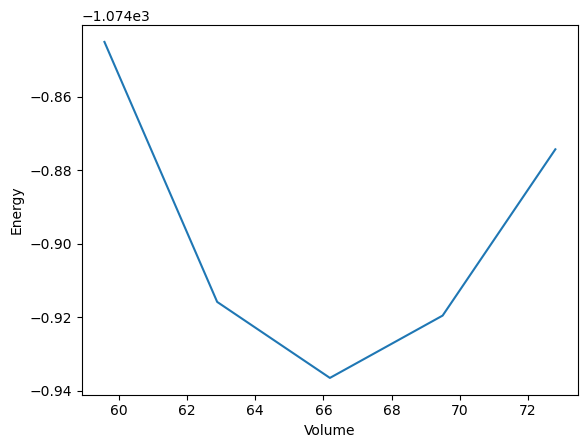

In [8]:
delayed_object_lst[-1].pull()

# Write Workflow with Output

In [9]:
def _remove_server_obj(nodes_dict: dict, edges_lst: list):
    server_lst = [k for k in nodes_dict.keys() if k.startswith("_server_obj_") or k.startswith("_return_job_object")]
    for s in server_lst:
        del nodes_dict[s]
        edges_lst = [ep for ep in edges_lst if s not in ep]
    return nodes_dict, edges_lst

In [10]:
def _get_nodes(connection_dict: dict, delayed_object_updated_dict: dict):
    return {
        connection_dict[k]: v._python_function if isinstance(v, DelayedObject) else v
        for k, v in delayed_object_updated_dict.items()
    }

In [11]:
def _get_working_directories(connection_dict: dict, delayed_object_updated_dict: dict):
    return {
        connection_dict[k]: v._job.working_directory 
        for k, v in delayed_object_updated_dict.items() if isinstance(v, DelayedObject)
    }

In [12]:
def _get_output(connection_dict: dict, delayed_object_updated_dict: dict):
    return {
        connection_dict[k]: v._job.output.to_builtin()["result"] 
        for k, v in delayed_object_updated_dict.items() if isinstance(v, DelayedObject)
    }

In [13]:
def get_graph(
    obj: object,
    obj_name: Optional[str] = None,
    nodes_dict: dict = {},
    edges_lst: list = [],
    link_node: Optional[str] = None,
) -> Tuple[dict, list]:
    """
    Get dictionary of nodes with node names as keys and node objects as values. In addition, generate a list of edges,
    consisting of pairs of node names which are linked together.

    Args:
        obj (object): Object to generate dictionary of nodes and list of edges
        obj_name (str): Name of the object
        nodes_dict (dict): Dictionary of nodes
        edges_lst (list): List of edges
        link_node (str): Name of the node to link to

    Returns:
        dict, list: dictionary of nodes and list of edges
    """
    node_name = get_node_name(node=obj, node_name=obj_name)
    nodes_dict.update({node_name: obj})
    if link_node is not None:
        edges_lst.append([link_node, node_name])
    if isinstance(obj, DelayedObject):
        for k, v in obj._input.items():
            if k == "kwargs":
                for sk, sv in v.items():
                    nodes_dict, edges_lst = get_graph(
                        obj=sv,
                        obj_name=sk,
                        nodes_dict=nodes_dict,
                        edges_lst=edges_lst,
                        link_node=node_name,
                    )
            else:
                nodes_dict, edges_lst = get_graph(
                    obj=v,
                    obj_name=k,
                    nodes_dict=nodes_dict,
                    edges_lst=edges_lst,
                    link_node=node_name,
                )
    elif isinstance(obj, dict) and any(
        [isinstance(v, DelayedObject) for v in obj.values()]
    ):
        for k, v in obj.items():
            nodes_dict, edges_lst = get_graph(
                obj=v,
                obj_name=k,
                nodes_dict=nodes_dict,
                edges_lst=edges_lst,
                link_node=node_name,
            )
    elif isinstance(obj, list) and any([isinstance(v, DelayedObject) for v in obj]):
        for k, v in enumerate(obj):
            nodes_dict, edges_lst = get_graph(
                obj=v,
                obj_name=str(k),
                nodes_dict=nodes_dict,
                edges_lst=edges_lst,
                link_node=node_name,
            )
    return nodes_dict, edges_lst

In [14]:
def get_node_name(node: object, node_name: Optional[str] = None) -> str:
    """
    Get name of the node

    Args:
        node (object): Node to get the name for
        node_name (str): Name of the node in case it is already defined

    Returns:
        str: name of the node
    """

    def remove_weak_reference(node):
        if isinstance(node, DelayedObject):
            node_copy = node.__copy__()
            node_copy._input = {k: v for k, v in node_copy._input.items() if
                                k not in ['_server_obj', '_return_job_object']}
            node_copy._input['kwargs'] = {k: remove_weak_reference(node=v) for k, v in
                                          node_copy._input['kwargs'].items()}
            return node_copy
        else:
            return node

    if isinstance(node, DelayedObject) and node_name is None:
        try:
            node_name = node._function.__name__
        except TypeError:
            node_name = str(node).replace("<", "").replace(" object at ", "")
    if node_name is None:
        try:
            node_name = node.__name__
        except AttributeError:
            node_name = str(type(node))
    try:
        return node_name + "_" + get_hash(binary=cloudpickle.dumps(remove_weak_reference(node=node)))
    except TypeError:
        return node_name

In [15]:
def write_workflow_json(
    delayed_object: DelayedObject, file_name: str = "workflow.json"
):
    nodes_dict, edges_lst = get_graph(obj=delayed_object, nodes_dict={}, edges_lst=[], link_node=None)
    nodes_dict, edges_lst = _remove_server_obj(
        nodes_dict=nodes_dict, edges_lst=edges_lst
    )
    delayed_object_updated_dict, match_dict = _get_unique_objects(nodes_dict=nodes_dict)
    connection_dict, lookup_dict = _get_connection_dict(
        delayed_object_updated_dict=delayed_object_updated_dict, match_dict=match_dict
    )
    nodes_new_dict = _get_nodes(
        connection_dict=connection_dict,
        delayed_object_updated_dict=delayed_object_updated_dict,
    )
    output_dict = _get_output(
        connection_dict=connection_dict,
        delayed_object_updated_dict=delayed_object_updated_dict,
    )
    working_dict = _get_working_directories(
        connection_dict=connection_dict,
        delayed_object_updated_dict=delayed_object_updated_dict,
    )
    edges_new_lst = _get_edges_dict(
        edges_lst=edges_lst,
        nodes_dict=nodes_dict,
        connection_dict=connection_dict,
        lookup_dict=lookup_dict,
    )

    nodes_store_lst = []
    for k, v in nodes_new_dict.items():
        if isfunction(v):
            mod = v.__module__
            if mod == "python_workflow_definition.pyiron_base":
                mod = "python_workflow_definition.shared"
            nodes_store_lst.append(
                {"id": k, "type": "function", "value": mod + "." + v.__name__, "output": output_dict[k], "working_directory": working_dict[k]}
            )
        elif isinstance(v, np.ndarray):
            nodes_store_lst.append({"id": k, "type": "input", "value": v.tolist()})
        else:
            nodes_store_lst.append({"id": k, "type": "input", "value": v})

    content = set_result_node(
        workflow_dict=update_node_names(workflow_dict={
            VERSION_LABEL: VERSION_NUMBER,
            NODES_LABEL: nodes_store_lst,
            EDGES_LABEL: edges_new_lst,
        })
    )
    
    with open(file_name, 'w') as f:
        json.dump(content, f, indent=4)

In [16]:
write_workflow_json(
    delayed_object=delayed_object_lst[-1], file_name="workflow_with_output.json"
)

In [17]:
!cat workflow_with_output.json

{
    "version": "0.1.0",
    "nodes": [
        {
            "id": 0,
            "type": "function",
            "value": "workflow.plot_energy_volume_curve",
            "output": null,
            "working_directory": "/home/jovyan/plot_energy_volume_curve_dc19cfec37bac99b15ae3d03389f1027_hdf5/plot_energy_volume_curve_dc19cfec37bac99b15ae3d03389f1027"
        },
        {
            "id": 1,
            "type": "function",
            "value": "python_workflow_definition.shared.get_list",
            "output": [
                59.57099524734306,
                62.88049498330623,
                66.18999471926999,
                69.49949445523349,
                72.80899419119692
            ],
            "working_directory": "/home/jovyan/get_list_87ed88092ee305492e23878e5a02ee15_hdf5/get_list_87ed88092ee305492e23878e5a02ee15"
        },
        {
            "id": 2,
            "type": "function",
            "value": "workflow.calculate_qe",
            "output": {
      